In [229]:
import py2neo
import pandas as pd

graph = py2neo.Graph()

query = """
MATCH (testClass:Class)-[:DECLARES]->(testMethod:Method)-[:ANNOTATED_BY]->()-[:OF_TYPE]->(:Type {name:"Test"}),
(testMethod)-[i:INVOKES]->(method:Method)<-[:DECLARES]-(type:Type)
WHERE type.fqn STARTS WITH "at.dropover" AND NOT type.name ENDS WITH "Test"
RETURN 
testClass.name as test_class,
testMethod.signature as test_method,
type.name as type,
method.signature as method,
COUNT(DISTINCT i) as invokes
"""

invokes = pd.DataFrame(graph.data(query))
invokes.head()

,invokes,method,test_class,test_method,type
0,1,int getTodoId(),TodoKeyTest,void testWithoutTodoId(),TodoKey
1,1,java.lang.String getText(),TodoGatewayTest,void responsiblePersonIsSetAtUpdate(),Todo
2,6,java.lang.String getSchedulingId(),SchedulingGatewayTest,void deleteUserDeep(),Scheduling
3,1,java.util.List getUserList(),SchedulingGatewayTest,void canCreateAndRead1User(),Scheduling
4,1,java.net.InetAddress getReferenceAddress(),FileTransferValidatorTest,void failsIfUploadIsCalledWithNullName(),FileTestUtils


In [230]:
invokes['prod'] = invokes.type + "#" + invokes.method.str.split().str[1].str.split("(").str[0]
invokes = invokes[~(invokes.method == "<init>")]
invokes['test'] = invokes.test_class + "#" + invokes.test_method.str.split().str[1].str.split("(").str[0]
invokes.head()

,invokes,method,test_class,test_method,type,prod,test
0,1,int getTodoId(),TodoKeyTest,void testWithoutTodoId(),TodoKey,TodoKey#getTodoId,TodoKeyTest#testWithoutTodoId
1,1,java.lang.String getText(),TodoGatewayTest,void responsiblePersonIsSetAtUpdate(),Todo,Todo#getText,TodoGatewayTest#responsiblePersonIsSetAtUpdate
2,6,java.lang.String getSchedulingId(),SchedulingGatewayTest,void deleteUserDeep(),Scheduling,Scheduling#getSchedulingId,SchedulingGatewayTest#deleteUserDeep
3,1,java.util.List getUserList(),SchedulingGatewayTest,void canCreateAndRead1User(),Scheduling,Scheduling#getUserList,SchedulingGatewayTest#canCreateAndRead1User
4,1,java.net.InetAddress getReferenceAddress(),FileTransferValidatorTest,void failsIfUploadIsCalledWithNullName(),FileTestUtils,FileTestUtils#getReferenceAddress,FileTransferValidatorTest#failsIfUploadIsCalle...


In [231]:
matrix = invokes.pivot_table(index=['test_class', 'test_method'], columns=['type', 'method'], values='invokes')
matrix = matrix.fillna(0)
matrix.head()

type                                                                                  AWS  \
method                                                   int countItems(java.lang.String)   
test_class     test_method                                                                  
AddCommentTest void blankSiteContainsRightComment()                                   0.0   
               void blankSiteContainsRightCreationTime()                              0.0   
               void blankSiteContainsRightUser()                                      0.0   
               void failsAtCommentNull()                                              0.0   
               void failsAtCreatorNull()                                              0.0   

type                                                                                                                             \
method                                                   void createTableV2(java.lang.String,java.lang.String,java.lang.String)   
test_class     test_method                                                                                                        
AddCommentTest void blankSiteContainsRightComment()                                                     0.0                       
               void blankSiteContainsRightCreationTime()                                                0.0                       
               void blankSiteContainsRightUser()                                                        0.0                       
               void failsAtCommentNull()                                                                0.0                       
               void failsAtCreatorNull()                                                                0.0                       

type                                                                                     \
method                                                   void setDropOverVersionV2(int)   
test_class     test_method                                                                
AddCommentTest void blankSiteContainsRightComment()                                 0.0   
               void blankSiteContainsRightCreationTime()                            0.0   
               void blankSiteContainsRightUser()                                    0.0   
               void failsAtCommentNull()                                            0.0   
               void failsAtCreatorNull()                                            0.0   

type                                                                                                           \
method                                                   void waitForTableToBecomeAvailable(java.lang.String)   
test_class     test_method                                                                                      
AddCommentTest void blankSiteContainsRightComment()                                                     0.0     
               void blankSiteContainsRightCreationTime()                                                0.0     
               void blankSiteContainsRightUser()                                                        0.0     
               void failsAtCommentNull()                                                                0.0     
               void failsAtCreatorNull()                                                                0.0     

type                                                                                                                                                           AddComment  \
method                                                   at.dropover.comment.boundary.GetCommentResponseModel doSync(at.dropover.comment.boundary.AddCommentRequestModel)   
test_class     test_method                                                                                                                                                  
AddCommentTest void blankSiteContainsRightComment()  

In [232]:
from sklearn.decomposition import PCA

model = PCA(n_components=2, random_state=0)
data = model.fit(matrix)
data

PCA(copy=True, iterated_power='auto', n_components=2, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [233]:
T = model.transform(matrix)
T[:5]

array([[-0.1825757 ,  0.17836169],
       [-0.1825757 ,  0.17836169],
       [-0.1825757 ,  0.17836169],
       [-0.1825757 ,  0.17836169],
       [-0.1825757 ,  0.17836169]])

In [234]:
from matplotlib import cm

classes = matrix.index.labels[0].values() / matrix.index.labels[0].max()
colors = [x for x in cm.hsv(classes)]
colors[:5]

[array([ 1.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  1.])]

In [235]:
from matplotlib.colors import rgb2hex

rgb_colors = [rgb2hex(x) for x in colors]
rgb_colors[:5]

['#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000']

Welche Testmethoden testen die Fachlichkeit???

In [236]:
methods_per_test_class = invokes.groupby(['test_class', 'test_method']).method.apply(list)
methods_per_test_class.head()

test_class      test_method                              
AddCommentTest  void blankSiteContainsRightComment()         [at.dropover.comment.boundary.GetCommentRespon...
                void blankSiteContainsRightCreationTime()    [at.dropover.comment.boundary.GetCommentRespon...
                void blankSiteContainsRightUser()            [at.dropover.comment.boundary.GetCommentRespon...
                void failsAtCommentNull()                    [at.dropover.comment.boundary.GetCommentRespon...
                void failsAtCreatorNull()                    [at.dropover.comment.boundary.GetCommentRespon...
Name: method, dtype: object

In [237]:
types_per_test_class = invokes.groupby(['test_class', 'test_method']).type.apply(list)
types_per_test_class.head()

test_class      test_method                              
AddCommentTest  void blankSiteContainsRightComment()         [AddComment]
                void blankSiteContainsRightCreationTime()    [AddComment]
                void blankSiteContainsRightUser()            [AddComment]
                void failsAtCommentNull()                    [AddComment]
                void failsAtCreatorNull()                    [AddComment]
Name: type, dtype: object

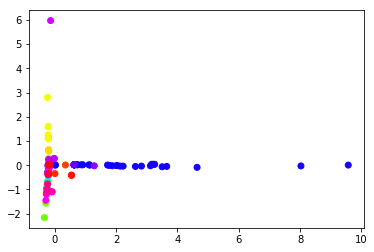

In [238]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(T[:,0], T[:,1], c=colors)

In [239]:
df = pd.DataFrame(T, columns=['x', 'y'])
df['test_class'] = matrix.reset_index().test_class
df['test_method'] = matrix.reset_index().test_method
df['methods'] = methods_per_test_class.reset_index().method
df['types'] = types_per_test_class.reset_index().type
df['color'] = rgb_colors
df.head()

,x,y,test_class,test_method,methods,types,color
0,-0.182576,0.178362,AddCommentTest,void blankSiteContainsRightComment(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
1,-0.182576,0.178362,AddCommentTest,void blankSiteContainsRightCreationTime(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
2,-0.182576,0.178362,AddCommentTest,void blankSiteContainsRightUser(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
3,-0.182576,0.178362,AddCommentTest,void failsAtCommentNull(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
4,-0.182576,0.178362,AddCommentTest,void failsAtCreatorNull(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000


In [240]:
# TODO: Bokeh, damit man weiß, welche Klassen das sind

In [241]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool


def scatter_with_hover(df, x, y, color='blue',
                       fig=None, cols=None, name=None, marker='o',
                       fig_width=800, fig_height=800, **kwargs):
    """
    Plots an interactive scatter plot of `x` vs `y` using bokeh, with automatic
    tooltips showing columns from `df`.
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data to be plotted
    x : str
        Name of the column to use for the x-axis values
    y : str
        Name of the column to use for the y-axis values
    fig : bokeh.plotting.Figure, optional
        Figure on which to plot (if not given then a new figure will be created)
    cols : list of str
        Columns to show in the hover tooltip (default is to show all)
    name : str
        Bokeh series name to give to the scattered data
    marker : str
        Name of marker to use for scatter plot
    **kwargs
        Any further arguments to be passed to fig.scatter
    Returns
    -------
    bokeh.plotting.Figure
        Figure (the same as given, or the newly created figure)
    Example
    -------
    fig = scatter_with_hover(df, 'A', 'B')
    show(fig)
    fig = scatter_with_hover(df, 'A', 'B', cols=['C', 'D', 'E'], marker='x', color='red')
    show(fig)
    Author
    ------
    Robin Wilson <robin@rtwilson.com>
    with thanks to Max Albert for original code example
    """

    # If we haven't been given a Figure obj then create it with default
    # size etc.
    if fig is None:
        fig = figure(width=fig_width, height=fig_height)

    # We're getting data from the given dataframe
    source = ColumnDataSource(data=df)

    # We need a name so that we can restrict hover tools to just this
    # particular 'series' on the plot. You can specify it (in case it
    # needs to be something specific for other reasons), otherwise
    # we just use 'main'
    if name is None:
        name = 'main'

    # Actually do the scatter plot - the easy bit
    # (other keyword arguments will be passed to this function)
    fig.scatter(x, y, source=source, name=name, marker=marker, color='color', **kwargs)

    # Now we create the hover tool, and make sure it is only active with
    # the series we plotted in the previous line
    hover = HoverTool(names=[name])

    if cols is None:
        # Display *all* columns in the tooltips
        hover.tooltips = [(c, '@' + c) for c in df.columns]
    else:
        # Display just the given columns in the tooltips
        hover.tooltips = [(c, '@' + c) for c in cols]

    hover.tooltips.append(('index', '$index'))

    # Finally add/enable the tool
    fig.add_tools(hover)

    return fig

In [242]:
from bokeh.io import push_notebook, show, output_notebook

plt = scatter_with_hover(df, 'x', 'y')
output_notebook()
show(plt)

Loading BokehJS ...

In [243]:
from sklearn.manifold import MDS

model = MDS()
T = model.fit_transform(matrix)
T[:5]

array([[-0.22340992,  0.11127742],
       [-0.22341024,  0.11127754],
       [-0.22340991,  0.11127742],
       [-0.22340992,  0.11127742],
       [-0.22341024,  0.11127754]])

In [244]:
df = pd.DataFrame(T, columns=['x', 'y'])
df['test_class'] = matrix.reset_index().test_class
df['test_method'] = matrix.reset_index().test_method
df['methods'] = methods_per_test_class.reset_index().method
df['types'] = types_per_test_class.reset_index().type
df['color'] = rgb_colors
df.head()

,x,y,test_class,test_method,methods,types,color
0,-0.22341,0.111277,AddCommentTest,void blankSiteContainsRightComment(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
1,-0.22341,0.111278,AddCommentTest,void blankSiteContainsRightCreationTime(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
2,-0.22341,0.111277,AddCommentTest,void blankSiteContainsRightUser(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
3,-0.22341,0.111277,AddCommentTest,void failsAtCommentNull(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
4,-0.22341,0.111278,AddCommentTest,void failsAtCreatorNull(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000


In [245]:
plt = scatter_with_hover(df, 'x', 'y')
output_notebook()
show(plt)

Loading BokehJS ...

In [246]:
from sklearn.manifold import Isomap

model = Isomap()
T = model.fit_transform(matrix)
T[:5]

array([[-1.26838922, -3.08059265],
       [-1.26838922, -3.08059265],
       [-1.26838922, -3.08059265],
       [-1.26838922, -3.08059265],
       [-1.26838922, -3.08059265]])

In [247]:
df = pd.DataFrame(T, columns=['x', 'y'])
df['test_class'] = matrix.reset_index().test_class
df['test_method'] = matrix.reset_index().test_method
df['methods'] = methods_per_test_class.reset_index().method
df['types'] = types_per_test_class.reset_index().type
df['color'] = rgb_colors
df.head()

,x,y,test_class,test_method,methods,types,color
0,-1.268389,-3.080593,AddCommentTest,void blankSiteContainsRightComment(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
1,-1.268389,-3.080593,AddCommentTest,void blankSiteContainsRightCreationTime(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
2,-1.268389,-3.080593,AddCommentTest,void blankSiteContainsRightUser(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
3,-1.268389,-3.080593,AddCommentTest,void failsAtCommentNull(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000
4,-1.268389,-3.080593,AddCommentTest,void failsAtCreatorNull(),[at.dropover.comment.boundary.GetCommentRespon...,[AddComment],#ff0000


In [248]:
plt = scatter_with_hover(df, 'x', 'y')
output_notebook()
show(plt)

Loading BokehJS ...